# Init Bionic VTOL

In [1]:
include("../Flyonic.jl");
using .Flyonic;

using Rotations; # used for initial position

using ReinforcementLearning;
using StableRNGs;
using Flux;
using Flux.Losses;
using Random;
using IntervalSets;
using LinearAlgebra;
using Distributions;

using Plots;
using Statistics;

using BSON: @save, @load # save mode

In [2]:
R_TOL = 0.5
N_WAYPOINTS = 4
SLOW_MODE = false

false

TODO:
evtl einfügen, dass wenn man über ziel drüber fliegt trotzdem den current point updatet 

In [3]:
create_visualization();

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat /Users/leonardoigler/.julia/packages/MeshCat/Ax8pH/src/visualizer.jl:73


In [4]:
# indicates how many threads Julia was started with. This is important for the multi-threaded environment
Threads.nthreads()

1

# Create Reinforcement Learning Environment

In [5]:
mutable struct VtolEnv{A,T,ACT,R<:AbstractRNG} <: AbstractEnv # Parametric Constructor for a subtype of AbstractEnv
    action_space::A # action space
    observation_space::Space{Vector{ClosedInterval{T}}} # observation space
    state::Vector{T} # current state space
    action::ACT # action space
    done::Bool # done
    t::T # time
    rng::R # random number generator

    name::String # for multible environoments
    visualization::Bool # visualization
    realtime::Bool # realtime
    
    # Everything you need aditionaly can also go in here.
    x_W::Vector{T} # current position
    v_B::Vector{T} # velocity
    R_W::Matrix{T} # current rotation
    ω_B::Vector{T} # rotation velocitiy
    wind_W::Vector{T} # wind
    Δt::T # Δ time
    
    # Current Bonus / Target
    num_waypoints::Int # includig start point
    waypoints::Vector{Vector{T}}
    reached_goal::BitVector
    
    progress::T
    progress_prev::T
    current_point::Int
    reached_goal_in_step::Bool
    
    r_tol::T
    projected_Position::Vector{T}

    slow_mode::Bool
end

In [6]:
# define a keyword-based constructor for the type declared in the mutable struct typedef. 
# It could also be done with the macro Base.@kwdef.
function VtolEnv(;
    rng = Random.GLOBAL_RNG, # Random number generation
    name = "vtol",
    visualization = false,
    realtime = false,
    kwargs... # let the function take an arbitrary number of keyword arguments 
)
    
    T = Float64; # explicit type which is used e.g. in state. Cannot be altered due to the poor matrix defininon.

    
    action_space = Space(
        ClosedInterval{T}[
            0.0..2.0, # propeller 1
            0.0..2.0, # propeller 2
            ], 
    )

    
    state_space = Space( # Three continuous values in state space.
        ClosedInterval{T}[
            # orientate yourself on the state space from the paper
            typemin(T)..typemax(T), # position along x
            typemin(T)..typemax(T), # position along z
            
            typemin(T)..typemax(T), # orientation along x
            typemin(T)..typemax(T), # orientation along z
            
            typemin(T)..typemax(T), # velocity along x BODY coordinates
            typemin(T)..typemax(T), # velocity along y BODY coordinates
            
            typemin(T)..typemax(T), # rotational velocity along z BODY coordinates
            
            typemin(T)..typemax(T), # position error along x (next gate - current position)
            typemin(T)..typemax(T), # position error along z (next gate - current position)
            
            typemin(T)..typemax(T), # way to next next gate x (next next gate - next gate)
            typemin(T)..typemax(T), # way to next next gate z (next next gate - next gate)
            # TODO: more points?
            ], 
    )
    
    num_waypoints = N_WAYPOINTS # number of waypoints, includig start point
    waypoints = generate_trajectory(num_waypoints) # trajectory with num_waypoints waypoints (+ start point) 
    reached_goal = falses(num_waypoints)
    
    if visualization #visualizes VTOL and waypoints
        create_VTOL(name, actuators = true, color_vec=[1.0; 1.0; 0.6; 1.0]);
        visualize_waypoints(waypoints, 0.15)
    end

    environment = VtolEnv(
        action_space,
        state_space, 
        zeros(T, length(state_space)), # current state, needs to be extended
        rand(action_space), #initialization action
        false, # episode done 
        0.0, # time
        rng, # random number generator  
        
        name,
        visualization,
        realtime,
        
        zeros(T, 3), # x_W, current position
        zeros(T, 3), # v_B, velocity
        [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], # R_W, current rotation, Float64... so T needs to be Float64
        zeros(T, 3), # ω_B
        zeros(T, 3), # wind_W
        T(0.025), # Δt 
        
        num_waypoints, # includig start point
        waypoints, 
        reached_goal,
        
        0.0, # progress
        0.0, # progress_prev
        2, # current point
        false, # reached_goal_in_step
        
        R_TOL, # r_tol
        zeros(T, 3),

        SLOW_MODE
    )
    
    
    reset!(environment)
    
    return environment
    
end;

Just for explanation:

1. A mutable Struct is created. A struct is a constructor and a constructor is a function that creates new objects.
2. A outer keyword-based constructor method is added for the type declared in the mutable struct typedef before.

So now we have a function with two methods. Julia will decide which method to call by multiple dispatch.

In [7]:
methods(VtolEnv)

# 2 methods for type constructor:
[1] VtolEnv(; rng, name, visualization, realtime, kwargs...) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/vertical_version_ethstyle_traj.ipynb:3
[2] VtolEnv(action_space::A, observation_space::Space{Array{ClosedInterval{T}, 1}}, state::Vector{T}, action::ACT, done::Bool, t::T, rng::R, name::String, visualization::Bool, realtime::Bool, x_W::Vector{T}, v_B::Vector{T}, R_W::Matrix{T}, ω_B::Vector{T}, wind_W::Vector{T}, Δt::T, num_waypoints::Int64, waypoints::Array{Vector{T}, 1}, reached_goal::BitVector, progress::T, progress_prev::T, current_point::Int64, reached_goal_in_step::Bool, r_tol::T, projected_Position::Vector{T}, slow_mode::Bool) where {A, T, ACT, R<:AbstractRNG} in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/vertical_version_ethstyle_traj.ipynb:2

# Define the RL interface

In [8]:
Random.seed!(env::VtolEnv, seed) = Random.seed!(env.rng, seed)
RLBase.action_space(env::VtolEnv) = env.action_space
RLBase.state_space(env::VtolEnv) = env.observation_space
RLBase.is_terminated(env::VtolEnv) = env.done
RLBase.state(env::VtolEnv) = env.state

In [9]:
function scale_for_slowmode(slow_mode::Bool, v_min::T, v_max::T, d_max::T, x_W::Vector{T}, projected_Position::Vector{T}, v_B::Vector{T}) where T
    
    if slow_mode == false
        return 1
    else
        if norm(v_B) > v_max
            s_vmax = 10^(v_max - norm(v_B))
        else
            s_vmax = 1
        end

        if norm(v_B) < v_min
            s_vmin = 10^(norm(v_B) - v_min)
        else
            s_vmin = 1
        end

        if norm(x_W - projected_Position) > d_max
            s_gd = exp(-norm(x_W - projected_Position) + d_max)
        else
            s_gd = 1
        end
        s = s_vmax * s_vmin * s_gd
    end
    return s
end



scale_for_slowmode (generic function with 1 method)

In [10]:
function computeReward(env::VtolEnv{A,T}) where {A,T}
    
    norm_way = 0.0 # DEBUG: save in environment
    for i in 1:(env.num_waypoints - 1)
        norm_way += norm(env.waypoints[i] - env.waypoints[i + 1])
    end

    v_min = 1.0 # min velocity
    v_max = 3.0 # max velocity
    d_max = 0.5


    s = scale_for_slowmode(env.slow_mode, v_min, v_max, d_max, env.x_W, env.projected_Position, env.v_B)
    

    k_p = 5.0 * s#env.num_waypoints / norm_way;# factor for progress (between current position and last position) reward 
    r_p = (env.progress - env.progress_prev); # reward for progress (between current position and last position)

    k_s = s * (2 * v_max * env.Δt)/norm_way #5.0 # factor for reached distance (overall) reward, TODO later add factor as in paper (p. 4)
    r_s = env.progress # reward for reached distance (overall)
    
    k_wp = 10.0 * env.num_waypoints # factor for reached gate reward
    r_wp = 0.0 # reward for reached gate, TODO: change to gates later (when gates != waypoints)
    if env.reached_goal_in_step
        r_wp = exp(-norm(env.x_W - env.waypoints[env.current_point - 1])/env.r_tol)
    end 

    k_ω = 0.01 # factor for too high body rate penalty
    norm_ω = norm(env.ω_B[3]) # penalty for body rate

    if env.x_W[3]<-2
        fall = 1
    else
        fall = 0
    end

    return k_p * r_p + k_s * r_s + k_wp * r_wp - k_ω * norm_ω -fall# - k_v * norm_v
    
end


RLBase.reward(env::VtolEnv{A,T}) where {A,T} = computeReward(env)

In [11]:
function RLBase.reset!(env::VtolEnv{A,T}) where {A,T}
    # Visualize initial state
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, [0.0; 0.0; 0.0; 0.0]);
    end
    
    env.x_W = [0.0; 0.0; 0.0];
    env.v_B = [0.0; 0.0; 0.0];
    env.R_W = Matrix(UnitQuaternion(RotZ(-pi/2.0)*RotY(-pi/2.0)*RotX(pi)));

    env.ω_B = [0.0; 0.0; 0.0];
    env.wind_W = [0.0; 0.0; 0.0];
    
    #env.num_waypoints = 4; # includig start point
    env.waypoints = generate_trajectory(env.num_waypoints);
    env.reached_goal = falses(env.num_waypoints);
    env.reached_goal[1] = true; # set first point to reached (start point)
    
    env.current_point = 2;
    env.reached_goal_in_step = false;
    #env.r_tol = 0.3;
    
    if env.visualization
        visualize_waypoints(env.waypoints, 0.15); # debug: other radius?
    end
    

    env.progress = 0.0;
    env.progress_prev = 0.0;
    
    
    env.state = [env.x_W[1]; # position along x
                 env.x_W[3]; # position along z
        
                 env.R_W[1,1]; # orientation along x
                 env.R_W[3,1]; # orientation along z
        
                 env.v_B[1]; # velocity along x BODY coordinates
                 env.v_B[2]; # velocity along y BODY coordinates  
        
                 env.ω_B[3]; # rotational velocity along z BODY coordinates
        
                 env.waypoints[2][1] - env.x_W[1]; # position error along x
                 env.waypoints[2][3] - env.x_W[3]; # position error along z
                 
                 0.0; # way to next next gate x (next next gate - next gate)
                 0.0] # way to next next gate z (next next gate - next gate)
    
    if env.num_waypoints >= 3
        env.state[10] = env.waypoints[3][1] - env.waypoints[2][1]; # way to next next gate x (next next gate - next gate)
        env.state[11] = env.waypoints[3][3] - env.waypoints[2][1]; # way to next next gate z (next next gate - next gate)
    end
        
    env.t = 0.0;
    env.action = [0.0, 0.0];
    env.done = false;

    env.projected_Position = [0; 0; 0]
    
    nothing

end;

In [12]:
# defines a methods for a callable object.
# So when a VtolEnv object is created, it has this method that can be called
function (env::VtolEnv)(a)
    # TODO: set flaps later in 3D
    # set the propeller trust and the two flaps 2D case
    next_action = [a[1], a[2], 0.0, 0.0]
   
    _step!(env, next_action)
end

In [13]:
env = VtolEnv();

In [14]:
methods(env) # Just to explain which methods the object has

# 3 methods for callable object:
[1] (env::VtolEnv)(a) in Main at /Users/leonardoigler/Documents/Studium/Semester 3/ADLR/Project/tum-adlr-01/src/2d/vertical_version_ethstyle_traj.ipynb:3
[2] (env::AbstractEnv)(action) in ReinforcementLearningBase
[3] (env::AbstractEnv)(action, player) in ReinforcementLearningBase

In [15]:
function _step!(env::VtolEnv, next_action)
    # caluclate wind impact
    v_in_wind_B = vtol_add_wind(env.v_B, env.R_W, env.wind_W)
    # caluclate aerodynamic forces
    torque_B, force_B = vtol_model(v_in_wind_B, next_action, eth_vtol_param);
    # Limit to 2D
    force_B[3] = 0.0; # Body Z
    env.v_B[3] = 0.0;
    torque_B[1] = 0.0; torque_B[2] = 0.0;  # Body X and Y
    env.ω_B[1] = 0.0; env.ω_B[2] = 0.0;
    # integrate rigid body dynamics for Δt
    env.x_W, env.v_B, env.R_W, env.ω_B, time = rigid_body_simple(torque_B, force_B, env.x_W, env.v_B, env.R_W, env.ω_B, env.t, env.Δt, eth_vtol_param)
    
    
    env.reached_goal_in_step = false;
    if norm(env.x_W - env.waypoints[env.current_point]) < env.r_tol
        env.reached_goal_in_step = true;
        env.reached_goal[env.current_point] = true;
        #env.current_point += 1;
    end
        
            
    # calculate progress on trajectory
    env.progress_prev = env.progress
    
    current_progress = 0.0
    line_segment, env.projected_Position = calculate_progress(env.waypoints, env.x_W)
    
    env.current_point = line_segment + 1

    for i in 2:(line_segment)
       current_progress +=  norm(env.waypoints[i] - env.waypoints[i - 1])  
    end
    current_progress += norm(env.waypoints[line_segment] - env.projected_Position)
    
    env.progress = current_progress
    

    if env.realtime
        sleep(env.Δt) # TODO: just a dirty hack. this is of course slower than real time.
    end

    # Visualize the new state 
    if env.visualization
        set_transform(env.name, env.x_W, QuatRotation(env.R_W));
        set_actuators(env.name, next_action)
        
        for i in eachindex(env.reached_goal)
            if env.reached_goal[i]
                create_sphere("fixgoal_$i", 0.2, color=RGBA{Float32}(1.0, 0.0, 0.0, 1.0));
                set_transform("fixgoal_$i", env.waypoints[i]);
            end
        end
    end
 

    env.t += env.Δt
    
    env.state[1] = env.x_W[1]; # position along x
    env.state[2] = env.x_W[3]; # position along z
    
    env.state[3] = env.R_W[1,1]; # orientation along x
    env.state[4] = env.R_W[3,1]; # orientation along z
    
    env.state[5] = env.v_B[1]; # velocity along x BODY coordinates
    env.state[6] = env.v_B[2]; # velocity along y BODY coordinates
    
    env.state[7] = env.ω_B[3];  # rotational velocity along z BODY coordinates
    
    
    if env.current_point <= env.num_waypoints
        env.state[8] = env.waypoints[env.current_point][1] - env.x_W[1]; # position error along x
        env.state[9] = env.waypoints[env.current_point][3] - env.x_W[3]; # position error along z
        
        if env.current_point <= env.num_waypoints - 1
            env.state[10] = env.waypoints[env.current_point + 1][1] - env.waypoints[env.current_point][1]; # way to next next gate x (next next gate - next gate)
            env.state[11] = env.waypoints[env.current_point + 1][3] - env.waypoints[env.current_point][3]; # way to next next gate z (next next gate - next gate)
        else
            env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
            env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
        end
    else
        env.state[8] = 0.0; # position error along x
        env.state[9] = 0.0; # position error along z
        env.state[10] = 0.0 # way to next next gate x (next next gate - next gate)
        env.state[11] = 0.0 # way to next next gate z (next next gate - next gate)
    end
        
    
    # Termination criteria
    # TODO: Use many termination criteria so that you do not train unnecessarily in wrong areas
    env.done = #true
        # After time... How fast is drone+Range of desired point
        # After reaching position (circle of r_tol)
        norm(env.ω_B) > 100.0 || 
        norm(env.v_B) > 100.0 || # stop if body is too fast # TODO: set higher later in fast training phase
        env.x_W[3] < -5.0 || # stop if body is below -5m
        env.t > env.num_waypoints * 10.0 ||# stop after 10s per point
        norm(env.x_W - env.projected_Position) > 5.0 || # too far off the path 
        env.current_point > env.num_waypoints ||# all points reached
        norm(env.x_W - env.waypoints[end])<env.r_tol

    nothing
end;

changed to 10s (5s before) per point and 5.0m too far off path (2.0 before)

In [16]:
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total  Time
random policy with VtolEnv | 2000   2000  0.8s


Test.DefaultTestSet("random policy with VtolEnv", Any[], 2000, false, false, true, 1.670770841603089e9, 1.670770842422146e9)

Show an overview of the environment.

# Setup of a reinforcement learning experiment.

In [17]:
seed = 123    
rng = StableRNG(seed)
    N_ENV = 8
    UPDATE_FREQ = 1024
    
    
    # define multiple environments for parallel training
    env = MultiThreadEnv([
        # use different names for the visualization
        VtolEnv(; rng = StableRNG(hash(seed+i)), name = "vtol$i") for i in 1:N_ENV
    ])

MultiThreadEnv(8 x VtolEnv)

In [18]:
# Define the function approximator
# TODO: change architecture eventually 
    ns, na = length(state(env[1])), length(action_space(env[1]))
    approximator = ActorCritic(
                actor = GaussianNetwork(
                    pre = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),#
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    ),
                    μ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                    logσ = Chain(Dense(128, na; initW = glorot_uniform(rng))),
                ),
                critic = Chain(
                    Dense(ns, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 128, tanh; initW = glorot_uniform(rng)),
                    Dense(128, 1; initW = glorot_uniform(rng)),
                ),
                optimizer = ADAM(1e-3),
            );

In [19]:
    agent = Agent( # A wrapper of an AbstractPolicy
        # AbstractPolicy: the policy to use
        # TODO: change eventually
        policy = PPOPolicy(;
                    approximator = approximator |> gpu,
                    update_freq=UPDATE_FREQ,
                    dist = Normal,
                    # For parameters visit the docu: https://juliareinforcementlearning.org/docs/rlzoo/#ReinforcementLearningZoo.PPOPolicy
                    ),
        
        # AbstractTrajectory: used to store transitions between an agent and an environment source
        trajectory = PPOTrajectory(;
            capacity = UPDATE_FREQ,
            state = Matrix{Float64} => (ns, N_ENV),
            action = Matrix{Float64} => (na, N_ENV),
            action_log_prob = Vector{Float64} => (N_ENV,),
            reward = Vector{Float64} => (N_ENV,),
            terminal = Vector{Bool} => (N_ENV,),
        ),
    );


┌ Info: The GPU function is being called but the GPU is not accessible. 
│ Defaulting back to the CPU. (No action is required if you want to run on the CPU).
└ @ Flux /Users/leonardoigler/.julia/packages/Flux/7nTyc/src/functor.jl:187


In [20]:
function saveModel(t, agent, env)
    model = cpu(agent.policy.approximator)   
    f = joinpath("./RL_models_l/", "vtol_2D_ppo_$t.bson") # TODO: evtl anpassen
    @save f model
    println("parameters at step $t saved to $f")
end;

In [21]:
function loadModel()
    f = joinpath("./RL_models_slow/", "vtol_2D_ppo_1500000.bson") # TODO: evtl anpassen
    @load f model
    return model
end;

In [22]:
function validate_policy(t, agent, env)
    run(agent.policy, test_env, StopAfterEpisode(1), episode_test_reward_hook)
    # the result of the hook
    println("test reward at step $t: $(episode_test_reward_hook.rewards[end])")
    
end;

episode_test_reward_hook = TotalRewardPerEpisode(;is_display_on_exit=false)
# create a env only for reward test
test_env = VtolEnv(;name = "testVTOL", visualization = true, realtime = true);

In [23]:
agent.policy.approximator = loadModel(); # TODO: un/comment

In [24]:
ReinforcementLearning.run(
    agent,
    env,
    StopAfterStep(2_500_000),
    ComposedHook(
        DoEveryNStep(saveModel, n=100_000), 
        DoEveryNStep(validate_policy, n=10_000)),
)

Progress:   0%|                                         |  ETA: 44.35 days

Progress:   0%|▏                                        |  ETA: 2:13:17

test reward at step 10000: 142.39234256091984


Progress:   0%|▎                                        |  ETA: 1:58:27

Progress:   1%|▎                                        |  ETA: 1:41:52

Progress:   1%|▎                                        |  ETA: 1:31:39

Progress:   1%|▎                                        |  ETA: 1:24:10

Progress:   1%|▍                                        |  ETA: 1:18:26

test reward at step 20000: 194.50674107886294


Progress:   1%|▍                                        |  ETA: 1:34:39

Progress:   1%|▍                                        |  ETA: 1:28:30

Progress:   1%|▍                                        |  ETA: 1:23:31

Progress:   1%|▌                                        |  ETA: 1:19:17

Progress:   1%|▌                                        |  ETA: 1:15:40

test reward at step 30000: 172.2941124490251


Progress:   1%|▌                                        |  ETA: 1:22:57

Progress:   1%|▌                                        |  ETA: 1:19:03

Progress:   1%|▋                                        |  ETA: 1:14:25

Progress:   2%|▋                                        |  ETA: 1:11:07

Progress:   2%|▋                                        |  ETA: 1:08:31

test reward at step 40000: 162.7018216528963


Progress:   2%|▋                                        |  ETA: 1:13:23

Progress:   2%|▊                                        |  ETA: 1:10:29

Progress:   2%|▊                                        |  ETA: 1:08:17

Progress:   2%|▊                                        |  ETA: 1:06:30

Progress:   2%|▉                                        |  ETA: 1:04:46

test reward at step 50000: 213.9913036764374


Progress:   2%|▉                                        |  ETA: 1:13:21

Progress:   2%|▉                                        |  ETA: 1:11:00

Progress:   2%|▉                                        |  ETA: 1:09:04

Progress:   2%|█                                        |  ETA: 1:07:25

Progress:   2%|█                                        |  ETA: 1:05:55

test reward at step 60000: 199.75587753047984


Progress:   2%|█                                        |  ETA: 1:10:15

Progress:   3%|█                                        |  ETA: 1:08:44

Progress:   3%|█▏                                       |  ETA: 1:06:47

Progress:   3%|█▏                                       |  ETA: 1:05:19

test reward at step 70000: 185.90134978431573


Progress:   3%|█▏                                       |  ETA: 1:08:53

Progress:   3%|█▏                                       |  ETA: 1:07:28

Progress:   3%|█▎                                       |  ETA: 1:06:12

Progress:   3%|█▎                                       |  ETA: 1:05:03

Progress:   3%|█▎                                       |  ETA: 1:03:59

test reward at step 80000: 157.7683049939955


Progress:   3%|█▍                                       |  ETA: 1:05:31

Progress:   3%|█▍                                       |  ETA: 1:03:36

Progress:   3%|█▍                                       |  ETA: 1:02:10

Progress:   4%|█▌                                       |  ETA: 1:01:03

test reward at step 90000: 165.50851644315574


Progress:   4%|█▌                                       |  ETA: 1:03:10

Progress:   4%|█▌                                       |  ETA: 1:02:15

Progress:   4%|█▌                                       |  ETA: 1:01:22

Progress:   4%|█▋                                       |  ETA: 1:00:32

Progress:   4%|█▋                                       |  ETA: 0:59:45

parameters at step 100000 saved to ./RL_models_l/vtol_2D_ppo_100000.bson


test reward at step 100000: 358.2390556182927


Progress:   4%|█▋                                       |  ETA: 1:18:40

Progress:   4%|█▊                                       |  ETA: 1:16:25

Progress:   4%|█▊                                       |  ETA: 1:15:12

Progress:   4%|█▊                                       |  ETA: 1:14:07

test reward at step 110000: 183.95241196177713


Progress:   4%|█▊                                       |  ETA: 1:15:50

Progress:   4%|█▉                                       |  ETA: 1:14:35

Progress:   5%|█▉                                       |  ETA: 1:13:30

Progress:   5%|█▉                                       |  ETA: 1:12:32

Progress:   5%|██                                       |  ETA: 1:11:37

test reward at step 120000: 135.73201859476575


Progress:   5%|██                                       |  ETA: 1:12:05

Progress:   5%|██                                       |  ETA: 1:11:09

Progress:   5%|██                                       |  ETA: 1:10:17

Progress:   5%|██▏                                      |  ETA: 1:09:29

Progress:   5%|██▏                                      |  ETA: 1:08:43

test reward at step 130000: 353.2888084815863


Progress:   5%|██▏                                      |  ETA: 1:22:32

Progress:   5%|██▎                                      |  ETA: 1:20:35

Progress:   5%|██▎                                      |  ETA: 1:19:31

Progress:   6%|██▎                                      |  ETA: 1:18:34

Progress:   6%|██▎                                      |  ETA: 1:31:09

test reward at step 140000: 335.9961896160701


Progress:   6%|██▍                                      |  ETA: 1:30:04

Progress:   6%|██▍                                      |  ETA: 1:29:03

Progress:   6%|██▍                                      |  ETA: 1:28:06

Progress:   6%|██▍                                      |  ETA: 1:27:11

Progress:   6%|██▌                                      |  ETA: 1:26:19

test reward at step 150000: 317.3422918073305


Progress:   6%|██▌                                      |  ETA: 1:35:34

Progress:   6%|██▌                                      |  ETA: 1:34:31

Progress:   6%|██▌                                      |  ETA: 1:33:30

Progress:   6%|██▋                                      |  ETA: 1:32:31

Progress:   6%|██▋                                      |  ETA: 1:31:31

test reward at step 160000: 352.86929480615487


Progress:   6%|██▋                                      |  ETA: 1:42:22

Progress:   7%|██▊                                      |  ETA: 1:40:39

Progress:   7%|██▊                                      |  ETA: 1:39:36

Progress:   7%|██▊                                      |  ETA: 1:38:36

test reward at step 170000: 211.75206637252458


Progress:   7%|██▊                                      |  ETA: 1:43:07

Progress:   7%|██▉                                      |  ETA: 1:42:02

Progress:   7%|██▉                                      |  ETA: 1:41:00

Progress:   7%|██▉                                      |  ETA: 1:39:59

Progress:   7%|██▉                                      |  ETA: 1:39:00

test reward at step 180000: 318.4612904357473


Progress:   7%|███                                      |  ETA: 1:48:30

Progress:   7%|███                                      |  ETA: 1:46:23

Progress:   7%|███▏                                     |  ETA: 1:44:55

Progress:   8%|███▏                                     |  ETA: 1:43:46

test reward at step 190000: 339.3550374096282


Progress:   8%|███▏                                     |  ETA: 1:52:42

Progress:   8%|███▏                                     |  ETA: 1:51:40

Progress:   8%|███▎                                     |  ETA: 1:50:40

Progress:   8%|███▎                                     |  ETA: 1:49:37

Progress:   8%|███▎                                     |  ETA: 1:48:35

parameters at step 200000 saved to ./RL_models_l/vtol_2D_ppo_200000.bson


test reward at step 200000: 184.58918480464578


Progress:   8%|███▎                                     |  ETA: 1:51:20

Progress:   8%|███▍                                     |  ETA: 1:50:19

Progress:   8%|███▍                                     |  ETA: 1:49:20

Progress:   8%|███▍                                     |  ETA: 1:48:23

Progress:   8%|███▍                                     |  ETA: 1:47:25

test reward at step 210000: 324.4861709051581


Progress:   8%|███▌                                     |  ETA: 1:55:17

Progress:   9%|███▌                                     |  ETA: 1:53:15

Progress:   9%|███▋                                     |  ETA: 1:52:17

Progress:   9%|███▋                                     |  ETA: 1:51:18

InterruptException: InterruptException:

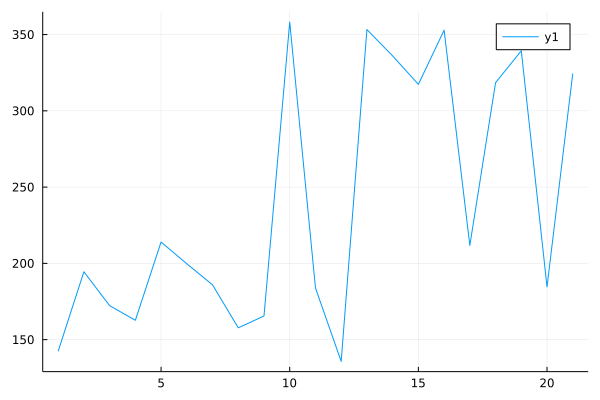

In [25]:
plot(episode_test_reward_hook.rewards)

In [26]:
close_visualization(); # closes the MeshCat visualization

In [27]:
x = [4.0; 0.0; 4.0]
gates = [[0.0; 0.0; 0.0], [3.0; 0.0; 3.0], [5.0; 0.0; 3.0]]
line_segment, projected_Position = calculate_progress(gates, x)
current_progress = 0

for i in 2:(line_segment)
    current_progress +=  norm(gates[i] - gates[i - 1])  
 end
 current_progress += norm(gates[line_segment] - projected_Position)
 
progress = current_progress

print(line_segment)
print("\n")
print(projected_Position)
print("\n")
print(progress)


2
[4.0, 0.0, 3.0]
5.242640687119285